In [1]:
from vlm_finetune import AutoVlmModel, ImageProcessor
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
import json
import evaluate
import pandas as pd

### Проведём сравнение всех моделей, зафайнтюненных на демо-ноутбуках

Загружаем датасет и создаём функция для предикта на сэмпле

In [2]:
def predict_on_test_dataset(model_name: str, model_path: str, test_data: list[dict[str, str]], prompt: str) -> list[str]:
    answers = []
    model = AutoVlmModel.from_name(
        model_name=model_name, 
        model_path=model_path,
        image_processor=ImageProcessor(image_size=(336, 336)) # ресайзим картинки, чтобы сэкономить память
    )
    for sample in tqdm(test_data):
        model_answer = model.predict(image=sample["image_path"], prompt=prompt)
        answers.append(model_answer)
    return answers

### Предикты моделей

In [3]:
with open("data/vet_dataset_test.json", "r") as file:
    test_data_ru = json.loads(file.read())
prompt_ru = "Поставь вероятный диагноз по рентгенограмме."

with open("data/vet_dataset_test_eng.json", "r") as file:
    test_data_eng = json.loads(file.read())
prompt_eng = "Make a probable diagnosis using the x-ray."

llava_name = "llava"
qwen_name = "qwen"
models = [
    "llava_tuned",
    "qwen25_tuned", 
    "qwen3_tuned", 
    "llava_tuned_eng", 
    "qwen25_tuned_eng", 
    "qwen3_tuned_eng"
]
bertscore = evaluate.load("bertscore")
ru_answers = [td["answer"] for td in test_data_ru]
eng_answers = [td["answer"] for td in test_data_eng]

eval_df = pd.DataFrame({
    "ru_answer": ru_answers,
    "eng_answer": eng_answers
})


for model in models:
    if model.startswith(llava_name):
        model_name = llava_name
    else:
        model_name = qwen_name

    if model.endswith("_eng"):
        prompt = prompt_eng
        test_data = test_data_eng
        lang = "en"
        answers = eng_answers
    else:
        prompt = prompt_ru
        test_data = test_data_ru
        lang = "ru"
        answers = ru_answers

    predictions = predict_on_test_dataset(
        model_name=model_name,
        model_path=f"models/{model}",
        test_data=test_data,
        prompt=prompt
    )
    model_name = model.replace("_tuned", "")
    score = bertscore.compute(predictions=predictions, references=answers, lang=lang)
    precision = score["precision"]
    recall = score["recall"]
    f1 = score["f1"]
    
    eval_df[f"{model_name}_answer"] = predictions
    eval_df[f"{model_name}_precision"] = precision
    eval_df[f"{model_name}_recall"] = recall
    eval_df[f"{model_name}_f1"] = f1

Loading checkpoint shards:   0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

Loading checkpoint shards:   0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

Loading checkpoint shards:   0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Loading checkpoint shards:   0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

In [4]:
eval_df.to_csv("data/models_eval.csv", index=False, sep=";")
eval_df.describe()

,llava_precision,llava_recall,llava_f1,qwen25_precision,qwen25_recall,qwen25_f1,qwen3_precision,qwen3_recall,qwen3_f1,llava_eng_precision,llava_eng_recall,llava_eng_f1,qwen25_eng_precision,qwen25_eng_recall,qwen25_eng_f1,qwen3_eng_precision,qwen3_eng_recall,qwen3_eng_f1
count,25.000000,25.000000,25.000000,25.000000,25.000000,25.000000,25.000000,25.000000,25.000000,25.000000,25.000000,25.000000,25.000000,25.000000,25.000000,25.000000,25.000000,25.000000
mean,0.800509,0.780929,0.790244,0.702295,0.670647,0.685833,0.657535,0.658578,0.657726,0.904407,0.871583,0.887460,0.827528,0.832066,0.829363,0.832324,0.852297,0.841485
std,0.088699,0.080624,0.082821,0.027431,0.027667,0.023927,0.047192,0.041966,0.042453,0.043698,0.033291,0.035863,0.048587,0.021400,0.032259,0.049137,0.023493,0.033125
min,0.639253,0.658337,0.648655,0.612049,0.620453,0.622061,0.501859,0.572144,0.534702,0.802818,0.819824,0.811933,0.714192,0.784323,0.747616,0.622863,0.807570,0.716221
25%,0.760354,0.716581,0.737819,0.693838,0.657191,0.671305,0.631310,0.638656,0.630472,0.871950,0.839596,0.862117,0.796205,0.814468,0.811754,0.828136,0.840056,0.825902
50%,0.812623,0.781308,0.801636,0.709534,0.670642,0.684434,0.657777,0.653744,0.653750,0.932167,0.878175,0.885354,0.811292,0.833777,0.828623,0.843178,0.849157,0.853222
75%,0.862586,0.815625,0.833437,0.723632,0.686034,0.702533,0.684911,0.685701,0.687537,0.939365,0.897487,0.919474,0.854062,0.851079,0.843043,0.860241,0.874668,0.862898
max,0.935415,0.959252,0.947183,0.739446,0.720661,0.728291,0.744879,0.727121,0.735893,0.961712,0.921229,0.941035,0.912024,0.865813,0.888318,0.866588,0.883562,0.873007


### Сравнение моделей на русском языке

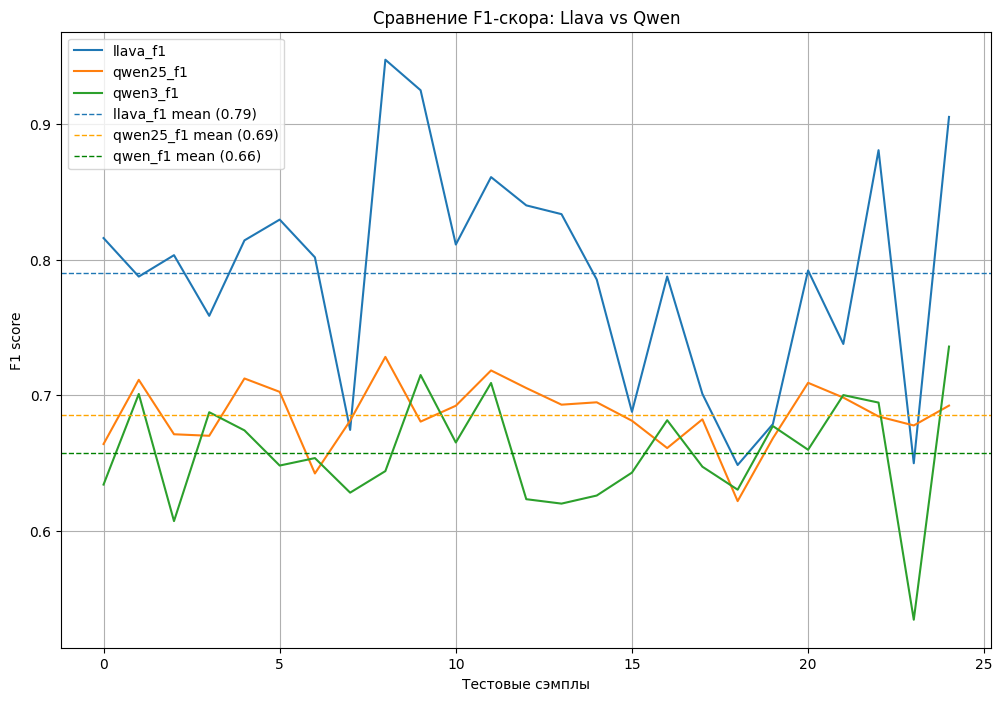

In [10]:
ax = eval_df[["llava_f1", "qwen25_f1", "qwen3_f1"]].plot(kind="line", figsize=(12, 8), title="Сравнение F1-скорa: Llava vs Qwen")
ax.set_xlabel("Тестовые сэмплы")
ax.set_ylabel("F1 score")
ax.axhline(eval_df["llava_f1"].mean(), linestyle="--", linewidth=1, label=f"llava_f1 mean ({eval_df['llava_f1'].mean():.2f})")
ax.axhline(eval_df["qwen25_f1"].mean(), linestyle="--", color="orange", linewidth=1, label=f"qwen25_f1 mean ({eval_df['qwen25_f1'].mean():.2f})")
ax.axhline(eval_df["qwen3_f1"].mean(), linestyle="--", color="green", linewidth=1, label=f"qwen_f1 mean ({eval_df['qwen3_f1'].mean():.2f})")
plt.grid(True)
ax.legend()
plt.show()

**LLava значительно лучше показала себя на данном датасете, для Qwen стоит поэкспериментировать с гиперпараметрами. Значимой разницы между Qwen 2.5 и Qwen 3 не наблюдается**

### Сравнение моделей на английском языке

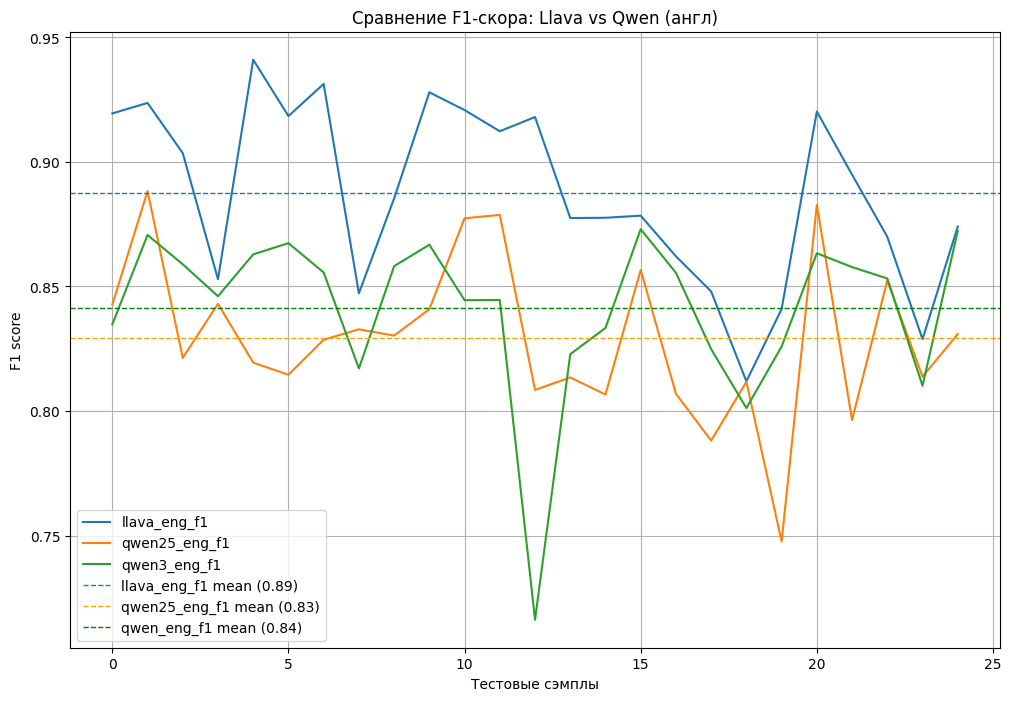

In [12]:
ax = eval_df[["llava_eng_f1", "qwen25_eng_f1", "qwen3_eng_f1"]].plot(kind="line", figsize=(12, 8), title="Сравнение F1-скорa: Llava vs Qwen (англ)")
ax.set_xlabel("Тестовые сэмплы")
ax.set_ylabel("F1 score")
ax.axhline(eval_df["llava_eng_f1"].mean(), linestyle="--", linewidth=1, label=f"llava_eng_f1 mean ({eval_df['llava_eng_f1'].mean():.2f})")
ax.axhline(eval_df["qwen25_eng_f1"].mean(), linestyle="--", color="orange", linewidth=1, label=f"qwen25_eng_f1 mean ({eval_df['qwen25_eng_f1'].mean():.2f})")
ax.axhline(eval_df["qwen3_eng_f1"].mean(), linestyle="--", color="green", linewidth=1, label=f"qwen_eng_f1 mean ({eval_df['qwen3_eng_f1'].mean():.2f})")
plt.grid(True)
ax.legend()
plt.show()

**LLava лучше показала себя на данном датасете, однако разница уже не столь значительна. Разницы между Qwen 2.5 и Qwen 3 уменьшилась**

### Сравнение между русской и английской моделями (LLava)

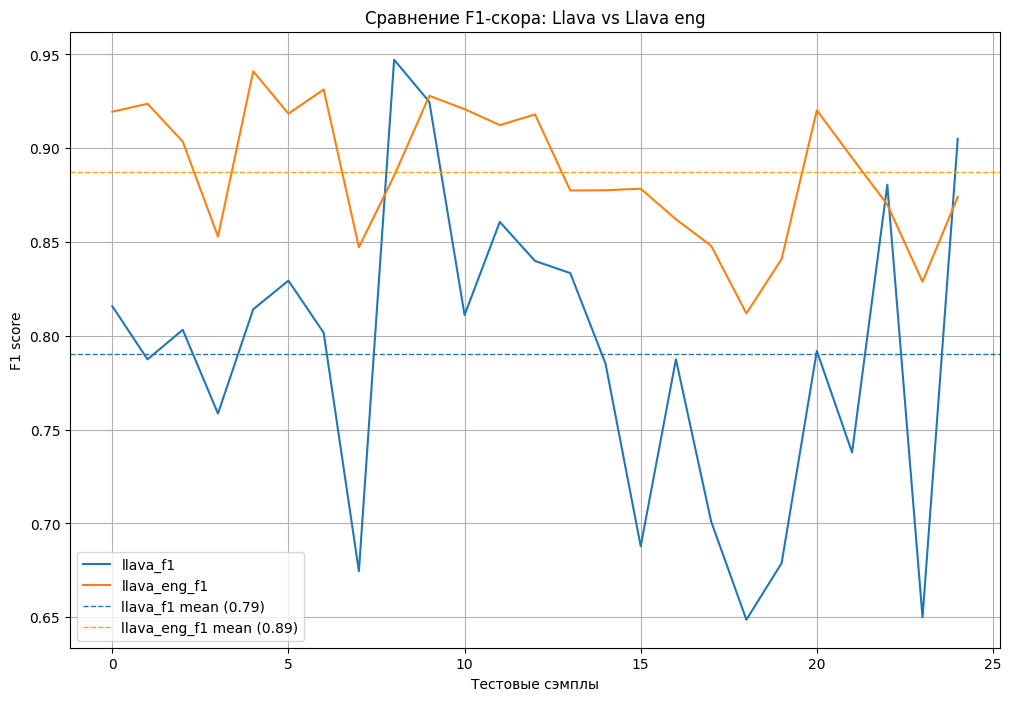

In [18]:
ax = eval_df[["llava_f1", "llava_eng_f1"]].plot(kind="line", figsize=(12, 8), title="Сравнение F1-скорa: Llava vs Llava eng")
ax.set_xlabel("Тестовые сэмплы")
ax.set_ylabel("F1 score")
ax.axhline(eval_df["llava_f1"].mean(), linestyle="--", linewidth=1, label=f"llava_f1 mean ({eval_df['llava_f1'].mean():.2f})")
ax.axhline(eval_df["llava_eng_f1"].mean(), linestyle="--", color="orange", linewidth=1, label=f"llava_eng_f1 mean ({eval_df['llava_eng_f1'].mean():.2f})")
plt.grid(True)
ax.legend()
plt.show()

**Скор англоязычной модели лучше примерно на 12.6%**

### Сравнение между русской и английской моделями (Qwen 2.5)

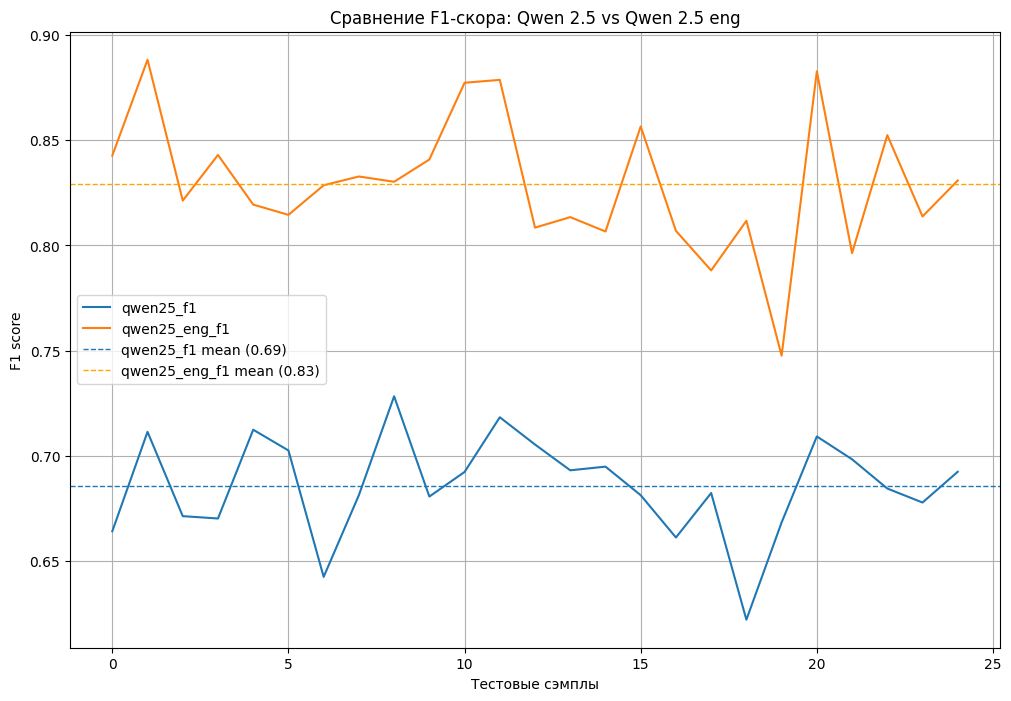

In [19]:
ax = eval_df[["qwen25_f1", "qwen25_eng_f1"]].plot(kind="line", figsize=(12, 8), title="Сравнение F1-скорa: Qwen 2.5 vs Qwen 2.5 eng")
ax.set_xlabel("Тестовые сэмплы")
ax.set_ylabel("F1 score")
ax.axhline(eval_df["qwen25_f1"].mean(), linestyle="--", linewidth=1, label=f"qwen25_f1 mean ({eval_df['qwen25_f1'].mean():.2f})")
ax.axhline(eval_df["qwen25_eng_f1"].mean(), linestyle="--", color="orange", linewidth=1, label=f"qwen25_eng_f1 mean ({eval_df['qwen25_eng_f1'].mean():.2f})")
plt.grid(True)
ax.legend()
plt.show()

**Скор англоязычной модели лучше примерно на 20%**

### Сравнение между русской и английской моделями (Qwen 3)

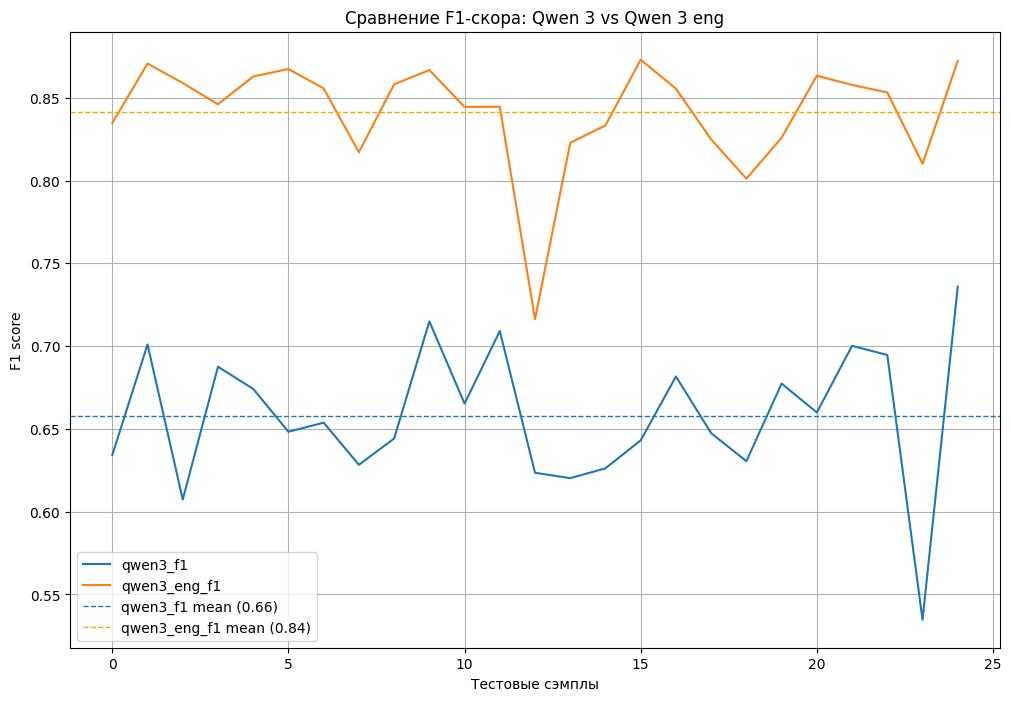

In [20]:
ax = eval_df[["qwen3_f1", "qwen3_eng_f1"]].plot(kind="line", figsize=(12, 8), title="Сравнение F1-скорa: Qwen 3 vs Qwen 3 eng")
ax.set_xlabel("Тестовые сэмплы")
ax.set_ylabel("F1 score")
ax.axhline(eval_df["qwen3_f1"].mean(), linestyle="--", linewidth=1, label=f"qwen3_f1 mean ({eval_df['qwen3_f1'].mean():.2f})")
ax.axhline(eval_df["qwen3_eng_f1"].mean(), linestyle="--", color="orange", linewidth=1, label=f"qwen3_eng_f1 mean ({eval_df['qwen3_eng_f1'].mean():.2f})")
plt.grid(True)
ax.legend()
plt.show()

**Скор англоязычной модели лучше примерно на 20%**